In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from darts import TimeSeries, concatenate
from darts.utils.callbacks import TFMProgressBar
from darts.models import NBEATSModel
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller
from darts.metrics import mape, rmse
from darts import concatenate

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import logging
logging.disable(logging.CRITICAL)

In [4]:
def generate_torch_kwargs():
    # run torch models on CPU, and disable progress bars for all model stages except training.
    return {
        "pl_trainer_kwargs": {
            "accelerator": "cpu",
            "callbacks": [TFMProgressBar(enable_train_bar_only=True)],
        }
    }

In [5]:
def display_forecast(pred_series, ts_transformed, forecast_type, start_date=None):
    plt.figure(figsize=(12, 5))
    if start_date:
        ts_transformed = ts_transformed.drop_before(start_date)
    ts_transformed.univariate_component(0).plot(label="actual")
    pred_series.plot(label=("historic " + forecast_type + " forecasts"))
    plt.title(
        "MAPE: {}".format(mape(scaler.transform(ts_transformed.univariate_component(0)), scaler.transform(pred_series)))+"/"
        "RMSE: {}".format(rmse(scaler.transform(ts_transformed.univariate_component(0)), scaler.transform(pred_series)))
    )
    plt.legend()

,Monthly Anamoly
DateTime,
1880-01-01,-5.194
1880-02-01,-1.075
1880-03-01,4.233
1880-04-01,9.538
1880-05-01,15.957


Text(0.5, 1.0, 'Seoul Temp')

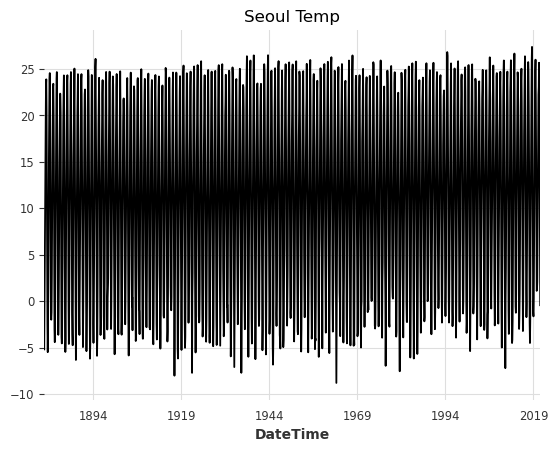

In [6]:
rawdata = pd.read_csv("../data/all_cities_month_temp_df.csv")
rawdata = rawdata.loc[rawdata.loc[:,"city_num"] == 0]
rawdata["DateTime"] = rawdata["year"].astype('str') + '-' + rawdata["month"].astype('str')
rawdata = rawdata.loc[:,["DateTime", "Monthly Anamoly"]]
rawdata["DateTime"] = pd.to_datetime(rawdata["DateTime"])
rawdata = rawdata.loc[rawdata['DateTime'] >= '1880-01-01']
rawdata.set_index("DateTime", inplace=True, drop=True)
display(rawdata.head())

rawdata["Monthly Anamoly"].plot()
plt.title("Seoul Temp")

In [7]:
series = TimeSeries.from_dataframe(rawdata).astype(np.float32)
scaler = Scaler()
train = series
# train, val = series.split_after(pd.Timestamp("20141201"))

Text(0.5, 1.0, 'Seoul Temp')

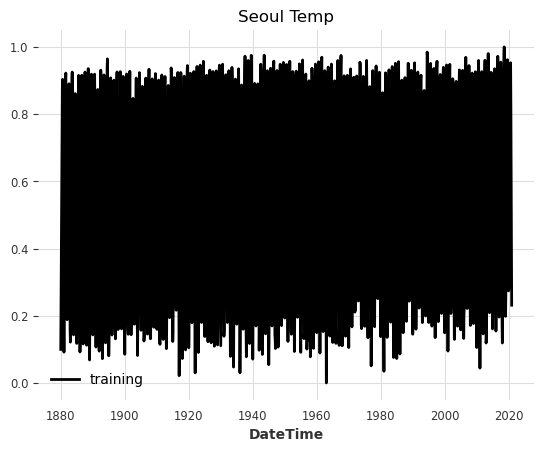

In [8]:
train_scaled = scaler.fit_transform(train)
# val_scaled = scaler.transform(val)
series_scaled = scaler.transform(series)

train_scaled.plot(label="training")
# val_scaled.plot(label="val")
plt.title("Seoul Temp")

In [9]:
model_name = "nbeats_run"
model_nbeats = NBEATSModel(
    input_chunk_length=480,
    output_chunk_length=60,
    generic_architecture=False,
    num_blocks=7,
    num_layers=4,
    layer_widths=512,
    n_epochs=100,
    nr_epochs_val_period=1,
    batch_size=64,
    random_state=156,
    model_name=model_name,
    # save_checkpoints=True,
    # force_reset=True,
    **generate_torch_kwargs(),
)

In [10]:
model_nbeats.fit(train_scaled)

Training: 0it [00:00, ?it/s]

NBEATSModel(output_chunk_shift=0, generic_architecture=False, num_stacks=30, num_blocks=7, num_layers=4, layer_widths=512, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=480, output_chunk_length=60, n_epochs=100, nr_epochs_val_period=1, batch_size=64, random_state=156, model_name=nbeats_run, pl_trainer_kwargs={'accelerator': 'cpu', 'callbacks': [<darts.utils.callbacks.TFMProgressBar object at 0x28f87b460>]})

In [11]:
#model_nbeats = NBEATSModel.load_from_checkpoint(model_name=model_name, best=True)

In [12]:
pred_series = model_nbeats.historical_forecasts(
    series_scaled,
    start=pd.Timestamp('2010-01-01'),
    forecast_horizon=60,
    stride=1,
    retrain=False,
    verbose=True,
)
pred_series = concatenate(pred_series)

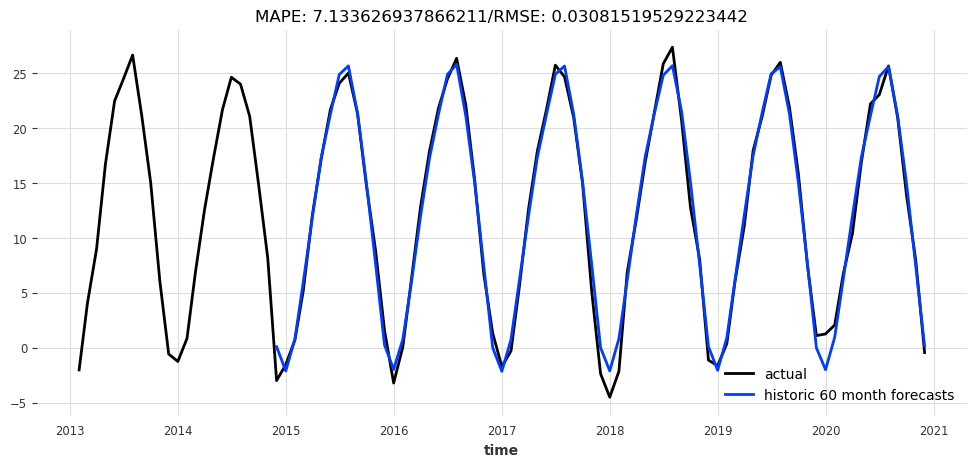

In [13]:
display_forecast(
    scaler.inverse_transform(pred_series),
    scaler.inverse_transform(series_scaled),
    "60 month",
    start_date=pd.Timestamp('2013-01-01'),
)

In [14]:
pred_series = model_nbeats.predict(12*80)
pred_series = concatenate(pred_series)

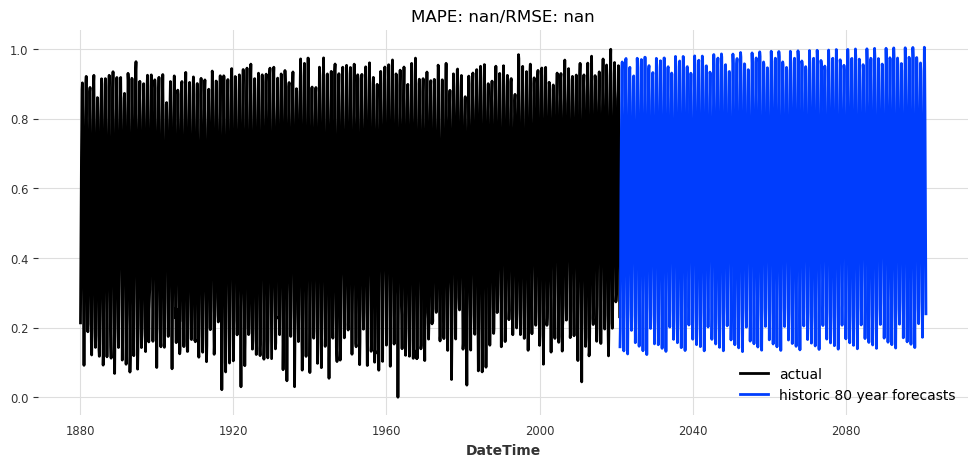

In [15]:
display_forecast(
    pred_series,
    series_scaled,
    "80 year",
    start_date=pd.Timestamp('1880-01-01'),
)

In [16]:
scaler.inverse_transform(series=pred_series).to_csv("a.csv")

In [17]:
forecast = pd.read_csv("a.csv").set_index("DateTime", drop=True)
forecast

,Monthly Anamoly
DateTime,
2021-01-01,-3.562837
2021-02-01,-1.668989
2021-03-01,6.108694
2021-04-01,13.055952
2021-05-01,17.396688
...,...
2100-08-01,25.889025
2100-09-01,20.932560
2100-10-01,13.479654


In [18]:
rawdata

,Monthly Anamoly
DateTime,
1880-01-01,-5.194
1880-02-01,-1.075
1880-03-01,4.233
1880-04-01,9.538
1880-05-01,15.957
...,...
2020-08-01,25.660
2020-09-01,20.951
2020-10-01,13.876


In [19]:
total = pd.concat([rawdata, forecast], axis=0)

In [20]:
total.to_csv("./NBEATS_forecast/NBEATS_forecast_seoul.csv", index=True, header=True)
total

,Monthly Anamoly
DateTime,
1880-01-01 00:00:00,-5.194000
1880-02-01 00:00:00,-1.075000
1880-03-01 00:00:00,4.233000
1880-04-01 00:00:00,9.538000
1880-05-01 00:00:00,15.957000
...,...
2100-08-01,25.889025
2100-09-01,20.932560
2100-10-01,13.479654


In [21]:
month12_ma = total["Monthly Anamoly"].rolling(window=12).mean()
year10_ma = total["Monthly Anamoly"].rolling(window=120).mean()

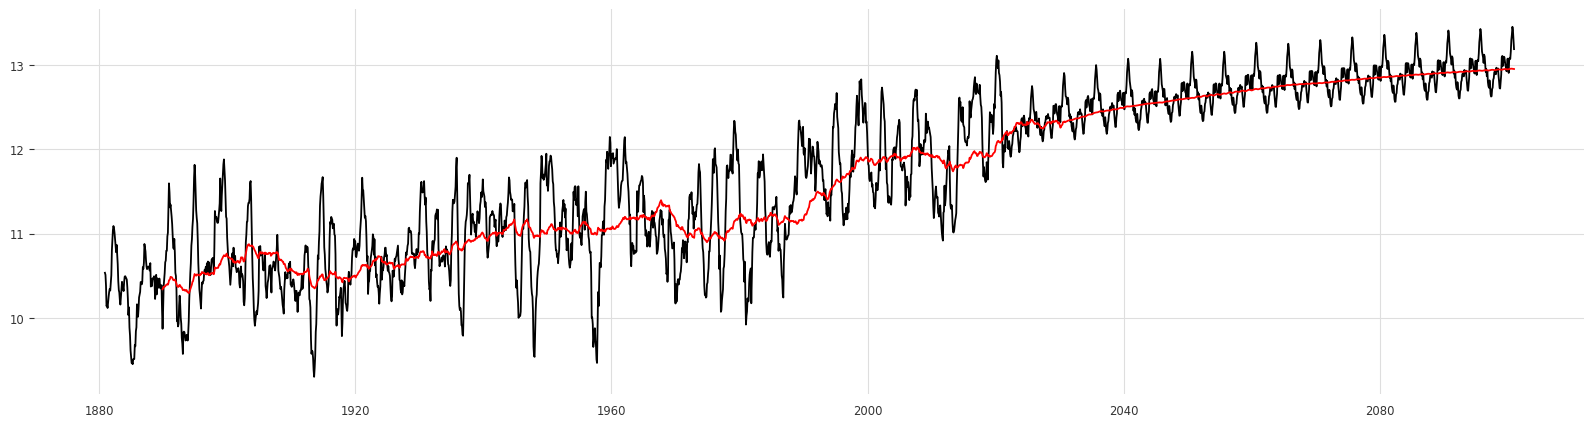

In [22]:
plt.figure(figsize=(20,5))
plt.plot(total.index,month12_ma)
plt.plot(total.index,year10_ma, color='red')